In [18]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, AllChem

script_directory = os.path.abspath(os.path.join('..', 'evaluation'))
sys.path.append(script_directory)

from prediction_reader import score_result

In [19]:
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

mulberry = '#830051'
gold = '#F0AB00'
graphite = '#3F4444'
magenta = '#D0006F'
lime_green = '#C4D600'
light_blue = '#68D2DF'
navy = '#003865'


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


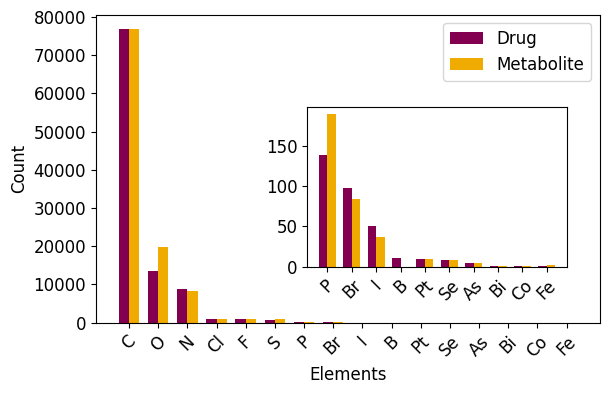

In [20]:
# Element count
def define_atoms(molecule):
    mol = Chem.MolFromSmiles(molecule)
    atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]
    atom_counts = Counter(atoms)
    return atom_counts


def analyse_atoms(data, column):
    total_atoms_count = Counter()

    for molecule in data[column]:
        atom_counts = define_atoms(molecule)
        total_atoms_count.update(atom_counts)

    return total_atoms_count


def print_atom_counts(atom_counts):
    for atom, count in atom_counts.items():
        print(f"{atom}: {count}")


def plot_histogram(parent_atom_counts, child_atom_counts, save_figure=None):

    all_atoms = set(list(parent_atom_counts.keys()) + list(child_atom_counts.keys()))

    atom_data = [(atom, parent_atom_counts.get(atom, 0), child_atom_counts.get(atom, 0)) for atom in all_atoms]
    sorted_atoms = sorted(atom_data, key=lambda x: x[1], reverse=True)

    full_order, parent_counts, child_counts = zip(*sorted_atoms)
    full_order = list(full_order)

    remaining_atoms = full_order[6:]

    plt.figure(figsize=(6.5, 4))
    bar_width = 0.35
    index = range(len(full_order))

    plt.bar(index, parent_counts, bar_width, label="Drug", color=mulberry)
    plt.bar(
        [i + bar_width for i in index],
        child_counts,
        bar_width,
        label="Metabolite",
        color=gold,
    )

    plt.xlabel("Elements")
    plt.ylabel("Count")
    plt.xticks([i + bar_width / 2 for i in index], full_order, rotation=45)
    plt.legend()

    if remaining_atoms:
        inset_ax = plt.axes([0.45, 0.25, 0.4, 0.4])  # [left, bottom, width, height]
        inset_index = range(len(remaining_atoms))
        inset_parent_counts = [
            parent_atom_counts.get(atom, 0) for atom in remaining_atoms
        ]
        inset_child_counts = [
            child_atom_counts.get(atom, 0) for atom in remaining_atoms
        ]

        inset_ax.bar(
            inset_index, inset_parent_counts, bar_width, color=mulberry, label="Drug"
        )
        inset_ax.bar(
            [i + bar_width for i in inset_index],
            inset_child_counts,
            bar_width,
            color=gold,
            label="Metabolite",
        )

        inset_ax.set_xticks([i + bar_width / 2 for i in inset_index])
        inset_ax.set_xticklabels(remaining_atoms, rotation=45)
        # inset_ax.set_title('Remaining Atoms')

    if save_figure is not None:
        os.makedirs("figures", exist_ok=True)
        plt.savefig(f"figures/{save_figure}.eps", format="eps")

    plt.show()


after = "../dataset/curated_data/combined_smiles_before_filters.csv"
data = pd.read_csv(after)

parent_atom_counts = analyse_atoms(data, "parent_smiles")
child_atom_counts = analyse_atoms(data, "child_smiles")

plot_histogram(parent_atom_counts, child_atom_counts, "element_count")

Max parent weights:  [4111.115376892007, 1354.5674001259997, 1322.6672601919997, 1261.8624973600001, 1225.60271968009]
Max child weights:  [2700.510203880001, 1343.5878012219996, 1294.6359600639996, 1277.8574119799998, 1277.8574119799998]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


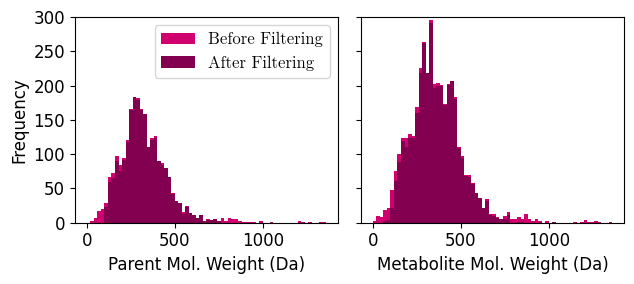

In [21]:
# def molecular_weight_analysis_2(dataset):
#     metabolite_weights, parent_weights = [], []

#     parents = dataset["parent_smiles"]
#     metabolites = dataset["child_smiles"]

#     for parent, metabolite in zip(parents, metabolites):
#         metabolite_weight = Descriptors.ExactMolWt(Chem.MolFromSmiles(metabolite))
#         metabolite_weights.append(metabolite_weight)

#         parent_weight = Descriptors.ExactMolWt(Chem.MolFromSmiles(parent))
#         parent_weights.append(parent_weight)

#     return metabolite_weights, parent_weights

def molecular_weight_analysis_2(dataset):
    # Use a set to store unique parent and child SMILES
    unique_parents_smiles = set(dataset["parent_smiles"])
    unique_child_smiles = set(dataset["child_smiles"])
    
    metabolite_weights, parent_weights = [], []

    for parent in unique_parents_smiles:
        parent_weight = Descriptors.ExactMolWt(Chem.MolFromSmiles(parent))
        parent_weights.append(parent_weight)

    for metabolite in unique_child_smiles:
        metabolite_weight = Descriptors.ExactMolWt(Chem.MolFromSmiles(metabolite))
        metabolite_weights.append(metabolite_weight)

    return metabolite_weights, parent_weights


def plot_molecular_weights_comparison(before_file, after_file, save_figure=None):
    df_before = pd.read_csv(before_file)
    df_after = pd.read_csv(after_file)

    metabolite_weights_before, parent_weights_before = molecular_weight_analysis_2(
        df_before
    )
    metabolite_weights_after, parent_weights_after = molecular_weight_analysis_2(
        df_after
    )

    fig, axes = plt.subplots(1, 2, figsize=(6.5, 3), sharey=True)
    plt.rcParams.update(
        {"font.size": 12, "font.family": "serif", "font.serif": ["NewComputerModern10"]}
    )

    top_five_maximums = sorted(parent_weights_before, reverse=True)[:5]
    print("Max parent weights: ", top_five_maximums)

    top_five_maximums = sorted(metabolite_weights_before, reverse=True)[:5]
    print("Max child weights: ", top_five_maximums)

    x_range = (0, 1360)
    bin_width = 20
    bins = np.arange(x_range[0], x_range[1] + bin_width, bin_width)

    axes[0].hist(
        parent_weights_before, bins=bins, color=magenta, label="Before Filtering"
    )
    axes[0].hist(
        parent_weights_after, bins=bins, color=mulberry, label="After Filtering"
    )
    axes[0].set_xlabel("Parent Mol. Weight (Da)")
    axes[0].set_ylabel("Frequency")
    # axes[0].set_xlim(0, 800)
    axes[0].legend()

    axes[1].hist(
        metabolite_weights_before, bins=bins, color=magenta, label="Before Filtering"
    )
    axes[1].hist(
        metabolite_weights_after, bins=bins, color=mulberry, label="After Filtering"
    )
    axes[1].set_xlabel("Metabolite Mol. Weight (Da)")
    # axes[1].set_xlim(0, 800)
    axes[1].set_ylim(0, 300)
    # axes[1].legend()

    if save_figure is not None:
        os.makedirs("figures", exist_ok=True)
        plt.savefig(f"figures/{save_figure}.eps", format="eps", bbox_inches='tight')

    plt.tight_layout()
    plt.show()


before = "../dataset/curated_data/combined_smiles_before_filters.csv"
after = "../dataset/curated_data/combined_smiles_clean.csv"
plot_molecular_weights_comparison(before, after, "weight_comparison")

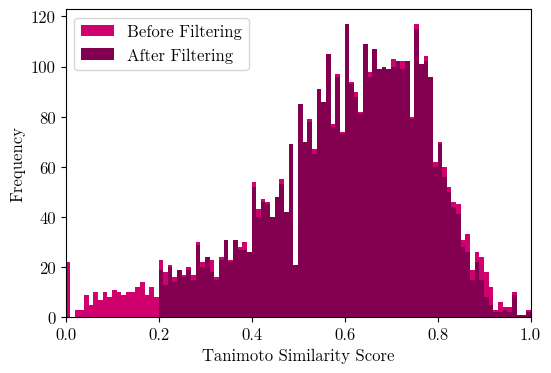

In [22]:
def fingerprint_similarity(csv_file):
    df = pd.read_csv(csv_file)
    parent_smiles = df["parent_smiles"].tolist()
    metabolite_smiles = df["child_smiles"].tolist()

    parent_mol = [Chem.MolFromSmiles(x) for x in parent_smiles]
    metabolite_mol = [Chem.MolFromSmiles(x) for x in metabolite_smiles]

    parent_fps = [
        AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024)
        for x in parent_mol
    ]
    metabolite_fps = [
        AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024)
        for x in metabolite_mol
    ]

    fingerprint_similarities = []
    for i in range(len(parent_smiles)):
        s = DataStructs.TanimotoSimilarity(parent_fps[i], metabolite_fps[i])
        fingerprint_similarities.append(s)

    return fingerprint_similarities


def plot_fingerprint_similarity(csv_file_before, csv_file_after, save_figure=None):

    plt.figure(figsize=(6, 4))
    # plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

    similarity_before = fingerprint_similarity(csv_file_before)
    similarity_after = fingerprint_similarity(csv_file_after)

    x_range = (0, 1)
    bin_width = 0.01
    bins = np.arange(x_range[0], x_range[1] + bin_width, bin_width)

    plt.hist(similarity_before, bins=bins, color=magenta, label="Before Filtering")
    plt.hist(similarity_after, bins=bins, color=mulberry, label="After Filtering")
    plt.xlabel("Tanimoto Similarity Score")
    plt.ylabel("Frequency")
    plt.legend()
    # plt.ylim(0, 120)
    plt.xlim(0, 1)

    if save_figure is not None:
        os.makedirs("figures", exist_ok=True)
        plt.savefig(f"figures/{save_figure}.eps", format="eps")

    plt.show()


before = "../dataset/curated_data/combined_smiles_before_filters.csv"
after = "../dataset/curated_data/combined_smiles_clean.csv"
plot_fingerprint_similarity(before, after, None)

In [23]:
def multi_boxplot(data, xlabel, ylabel, xticks, labels, location, save_figure=None, ylim=None):
    
    plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})
    plt.figure(figsize=(6, 3))

    colour_scheme = ['#52B297', '#8E4A93', '#009EE7', '#EF766E']

    box_width = 0.2

    for i in range(len(data)):
        boxprops = dict(linestyle='-', linewidth=1, color='black', facecolor=colour_scheme[i])
        medianprops = dict(linestyle='--', linewidth=1, color='none')
        meanprops = dict(linestyle='-', linewidth=1, color='black')

        plt.boxplot(data[i], positions=np.arange(len(data[i])) + i * box_width, widths=box_width, patch_artist=True,
                    boxprops=boxprops, showmeans=True, meanline=True, medianprops=medianprops, meanprops=meanprops, label=labels[i])
        

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    central_positions = np.arange(len(data[0])) + (len(data) * box_width / 2) - (box_width / 2)
    plt.xticks(central_positions, xticks)
    
    if ylim is not None:
        plt.ylim(-0.005, ylim)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    if location is not None:
        plt.legend(loc=location)

    if save_figure is not None:
        os.makedirs('figures', exist_ok=True)
        plt.savefig(f'figures/{save_figure}.eps', format='eps')

    
    plt.show()

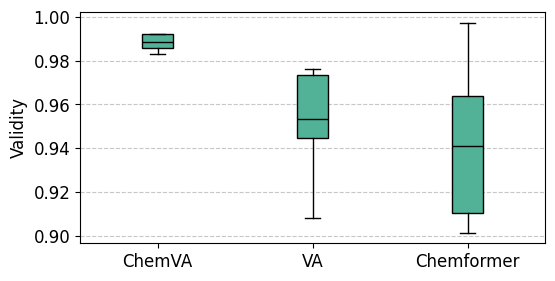

In [24]:
# Validity comparison plot

VA_comb = [0.9763157894736842, 0.9723684210526315, 0.9078947368421053, 0.9567567567567568]

'''
Validity: 0.953 +/- 0.001
Mean number of SMILES per drug: 16.117 +/- 0.161 / 20

Total identified metabolites: 24 / 271
Total number of predictions: 2434
'''

chemVA_comb = [0.9921052631578947, 0.9828947368421053, 0.9868421052631579, 0.9918918918918919]

'''
Validity: 0.988 +/- 0.000
Mean number of SMILES per drug: 14.461 +/- 0.085 / 20

Total identified metabolites: 37 / 271
Total number of predictions: 2184
'''

chemf_comb = [0.9131578947368421, 0.9013157894736842, 0.9526315789473684, 0.9972972972972973]

'''
Validity: 0.941 +/- 0.002
Mean number of SMILES per drug: 2.247 +/- 0.298 / 20

Total identified metabolites: 0 / 271
Total number of predictions: 340
'''

comb = [chemVA_comb, VA_comb, chemf_comb]

data = [comb]

xlabel = None
ylabel = 'Validity'
xticks = ['ChemVA', 'VA', 'Chemformer']
labels = ['comb', 'rand', 'base', 'mask']

multi_boxplot(data, xlabel, ylabel, xticks, labels, None, None)

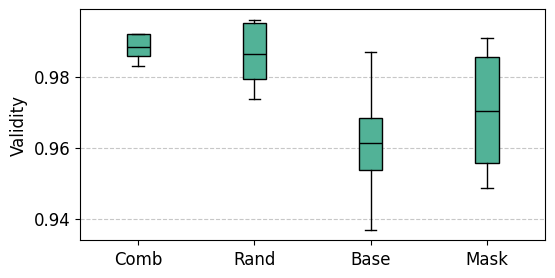

In [25]:
# Validity variants comparison plot

chemVA_comb = [0.9921052631578947, 0.9828947368421053, 0.9868421052631579, 0.9918918918918919]

'''
Validity: 0.988 $\pm$ 0.000
Mean number of SMILES per drug: 14.461 $\pm$ 0.085 / 20

Total identified metabolites: 37 / 271
Total number of predictions: 2184
'''

chemVA_mask = [0.9907894736842106, 0.9486842105263158, 0.9578947368421052, 0.9837837837837838]

'''
Validity: 0.970 $\pm$ 0.000
Mean number of SMILES per drug: 18.273 $\pm$ 0.091 / 20

Total identified metabolites: 37 / 271
Total number of predictions: 2759
'''

chemVA_rand = [0.9960526315789474, 0.9947368421052631, 0.9736842105263158, 0.981081081081081]

'''
Validity: 0.986 $\pm$ 0.000
Mean number of SMILES per drug: 14.352 $\pm$ 0.437 / 20

Total identified metabolites: 34 / 271
Total number of predictions: 2168
'''

chemVA_base = [0.9868421052631579, 0.9592105263157895, 0.9368421052631579, 0.9621621621621622]

'''
Validity: 0.961 $\pm$ 0.000
Mean number of SMILES per drug: 17.958 $\pm$ 0.246 / 20

Total identified metabolites: 40 / 271
Total number of predictions: 2712
'''

comb = [chemVA_comb, chemVA_rand, chemVA_base, chemVA_mask]

data = [comb]

xlabel = None
ylabel = 'Validity'
xticks = ['Comb', 'Rand', 'Base', 'Mask']
# labels = ['comb', 'rand', 'base', 'mask']

multi_boxplot(data, xlabel, ylabel, xticks, labels, None, None)

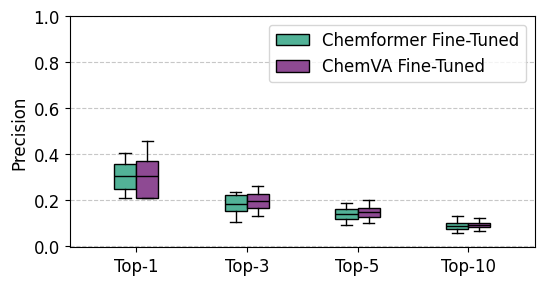

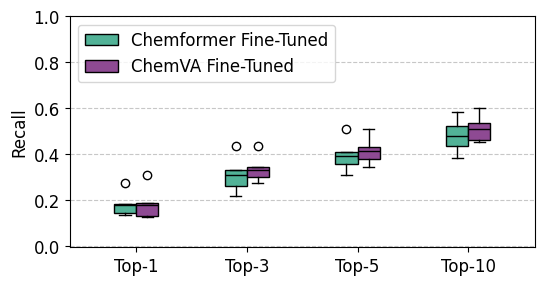

In [26]:
# After pre-training
bs = 4

recall_initial, precision_initial, score_one_initial, score_all_initial = score_result('../evaluation/alohomora/result_chemf_base_metabolic.csv', bs, False)
recall_baseline, precision_baseline, score_one_baseline, score_all_baseline = score_result('../evaluation/alohomora/result_base.csv', bs, False)

precision = [precision_initial[0:4], precision_baseline[0:4]]
recall = [recall_initial[0:4], recall_baseline[0:4]]
score_one = [score_one_initial[0:4], score_one_baseline[0:4]]
score_all = [score_all_initial[0:4], score_all_baseline[0:4]]

xlabel = None
xticks = ['Top-1', 'Top-3', 'Top-5', 'Top-10']
labels = ['Chemformer Fine-Tuned', 'ChemVA Fine-Tuned']

ylabel = 'Precision'
multi_boxplot(precision, xlabel, ylabel, xticks, labels, 'upper right', None, 1)

ylabel = 'Recall'
multi_boxplot(recall, xlabel, ylabel, xticks, labels, 'upper left', None, 1)

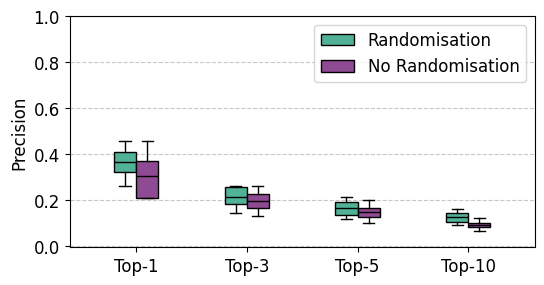

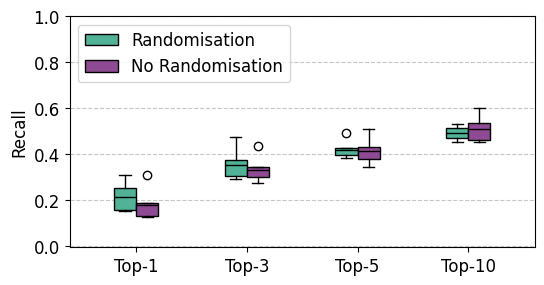

In [27]:
# Baseline comparison
bs = 4

recall_base, precision_base, score_one_base, score_all_base = score_result('../evaluation/alohomora/result_base_rand.csv', bs, False)
recall_baseline, precision_baseline, score_one_baseline, score_all_baseline = score_result('../evaluation/alohomora/result_base.csv', bs, False)

precision = [precision_base[0:4], precision_baseline[0:4]]
recall = [recall_base[0:4], recall_baseline[0:4]]
score_one = [score_one_base[0:4], score_one_baseline[0:4]]
score_all = [score_all_base[0:4], score_all_baseline[0:4]]

xlabel = None
xticks = ['Top-1', 'Top-3', 'Top-5', 'Top-10']
labels = ['Randomisation', 'No Randomisation']

ylabel = 'Precision'
multi_boxplot(precision, xlabel, ylabel, xticks, labels, 'upper right', None, 1)

ylabel = 'Recall'
multi_boxplot(recall, xlabel, ylabel, xticks, labels, 'upper left', None, 1)